# Modeling Workflow
In this module, we cover the modeling workflow from defining the model, running simulations, evaluating the model, and using it for optimization. The learning outcomes of this module are:

* Understand modeling workflow, with an ability to provide a detailed case example
* Be able to use a reinforcement learning model of multitasking while driving
* Be able to use Bayesian likelihood free inference to fit model parameters
* Understand how parameterized simulation models can be used to explore design candidates

The workflow used in this notebook can be illustrated like this.

<br><br>

<div>
<img src="workflow.png" width="800">
</div>

Please note that this is not a general workflow that can be used to describe every model, but a description of the process of this notebook. For a more general theory of modeling workflow, you can read this Wilson & Collins 2019 paper: https://elifesciences.org/articles/49547

**Note**. The word "model" has multiple meanings. A model can refer to the whole interactive task, including the user, or it can refer to just the user's cognition, or it can even refer to a specific internal model that the user has of the task. In this notebook, from now on, we will be using the following exact (but narrow) definitions.

* An *agent* takes actions to reach goals.
* The agent utilises a *policy*, which tells what the agent does in a particular state.
* The agent is expected to follow a *bounded optimal policy*, meaning it generally does what is best for it in the long term.
* The agent interacts with an *environment*, which for our computational is formalised. The resulting interaction of the formalised environment and the agent is called *simulation* of the interactive task.
* The agent has an internal representation of the dynamics of the environment. Here, we call that a *model*, which, given the current state of the environment and an action taken by the agent, provides a prediction of what the next state will be.  

## Case: Multitasking while Driving
The module will make use of a computational cognitive model that simulates driver multitasking (Jokinen, Kujala, & Oulasvirta 2021: https://journals.sagepub.com/doi/10.1177/0018720820927687

The model architecture takes the form of hierarchical control system, where different parts of the hierarchy are responsible for managing one part of the overall task. As illustrated above, the task is accomplished by three components.

<br><br>

<div>
<img src="driving.png" width="500">
</div>

<br>

Each "box" is its own RL agent, responsible only for its own task: driving (the primary task), in-car visual search (the secondary task), or supervision (deciding which task to attend). The isolation of these agents makes it possible to define each one separately from all others. Next, we define the driving task by following the modeling workflow outlined in the figure. Appendix 1 contains a walkthrough of how to create the full task model.

Driving in a naturalistic setting is a complicated task, which involves a large number of relevant environmental features, such as details about the road, other traffic, pedestrians, street signs, driving speed, orientation of the steering wheel, amount of fuel left, etc. In order to simplify the task into a manageable simulation, we here reduce the task to its simplest form. We define driving as a control task, where the car has a position on the lane. Depending on the speed $S$ of the car and angle of the steering wheel $\omega$, the next position $x$ of the car on the lane is dictated by its previous position.

$$ x_{t+1} = x_t + sin(\omega) \cdot S \cdot \tau, $$

where $\tau$ is a constant indicating the length of one tick of the simulation in seconds.

We can then define the driver *agent*. At any time step $t$ the agent can take actions $\omega_t \in [\omega_{min},\omega_{max}]$ to steer the car. It receives a real-valued reward based on the position of the car on the lane: if the position at a time step $x_t$ is less than $x_min$ or more than $x_max$, the agent receives a negative reward. Otherwise it receives a reward of zero.

We can now implement a simplified version of the driving environment and agent. Please note that this is not the full model, but is used here for demonstrative purposes.

In [119]:
# Implement the driver from the scratch
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import matplotlib.pyplot as plt

class driver(Env):
    def __init__(self, speed = 17, oob_reward = -1):
        self.speed = speed # m/s
        self.oob_reward = oob_reward # reward from lane violation
        
        self.threshold = 0.2 # oob
        
        self.step_time = 0.1 # seconds
        
        # Steering wheel extrema
        self.max_steer = 0.025
        # How many discrete steering actions
        self.actions = 10
        # Action related noise
        self.action_noise = 0
        
        self.action_space = Discrete(self.actions)
        
        # Observe current lane position
        self.observation_space = Box(low=0, high=1, shape = (1,))
        
        self.log = False
        
        self.reset()
        
    def reset(self):
        self.x = 0.5 # in the middle of the lane
        self.time = 0
        self.trace = {}
        self.trace["action"] = []
        self.trace["x"] = []
        return [self.x]
    
    # Given a discrete action, return a true steering position
    def action_to_steer(self, action):
        a = self.action_space.n/2
        return (action-a)*self.max_steer/a
    
    def update_car_pos(self, action):
        steer = self.action_to_steer(action)
        # Add action related noise
        steer += abs(steer)*np.random.logistic(0, self.action_noise)
        # Limit steer
        steer = min(max(steer, -self.max_steer), self.max_steer)
        self.x += math.sin(steer) * self.speed * self.step_time
        
    def step(self, action):
        done = False
        
        self.update_car_pos(action)
        
        if self.log:
            self.trace["action"].append(action)
            self.trace["x"].append(self.x)
        
        if self.x < self.threshold or self.x > 1 - self.threshold:
            reward = self.oob_reward
        else:
            reward = 0
            
        # Limit x
        self.x = max(min(self.x,1),0)

        return [self.x], reward, done, {}
    
    def plot_trace(self):
        plt.close()
        plt.ylim(0,1)
        ax = plt.gca()
        ax.invert_yaxis()
        t = np.linspace(0,len(self.trace["x"])*self.step_time, len(self.trace["x"]))
        plt.scatter(t, self.trace["x"])
        

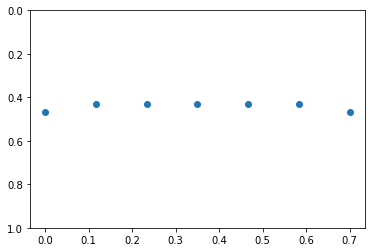

In [120]:
# Let's try the driving task!

d = driver(17)
d.log = True
d.reset()
d.step(1) # hard left steer
d.step(1) # hard left steer
d.step(5) # drive forward
d.step(5) # drive forward
d.step(5) # drive forward
d.step(5) # drive forward
d.step(9) # hard right steer
d.plot_trace()

Now that a very simple driving environment and agent have been defined, we can train a RL model. We'll use PPO for faster convergence than the original paper, which used tabular Q learning.

In [121]:
from stable_baselines3 import PPO
d.log = False
d_agent = PPO("MlpPolicy", d, device="cpu", verbose = 0)

d_agent.learn(total_timesteps = 10000) # This is going to take a couple of seconds.

In [122]:
# Produce a trace from the agent.
def simulate_driver(driver, agent, timesteps = 1000):
    driver.log = True
    state = driver.reset()
    for i in range(timesteps):
        action, _ = agent.predict(state)
        state , _, _, _ = driver.step(action)
    driver.plot_trace()
    driver.log = False

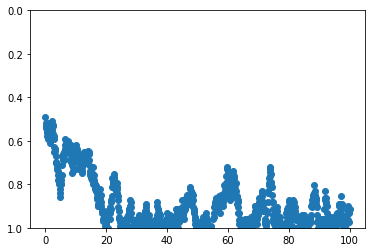

In [123]:
simulate_driver(d, d_agent)

## Introducing Bounds

Now that the environmental dynamcis and the agent's goals and available actions have been defined, we can ask: how to make the RL agent behave more like a human? To that end, we should specify bounds.

We start with action related noise: larger steering wheel angles are associated with more noise. 

In [ ]:
d = driver(17)
d.action_noise = 0.02
d_agent = PPO("MlpPolicy", d, device="cpu", verbose = 0)

d_agent.learn(total_timesteps = 50000) # This is going to take about 60 seconds.
simulate_driver(d, d_agent)

In [113]:
import run_experiment
import multitasking_agent

# Simulation

Now that we have defined the full model architecture for multitasking while driving, we can use it to produce simulated results and evaluate the face-validity of these results. We will be focusing on two face-valid hypotheses. First, increasing driving speed should result in shorter in-car glance duration. Second, prioritising driving safety should result in more time spent driving at the cost of the secondary task.

In [117]:
params = {"speed": 17,
          "obs_prob": 0.8,
          "an": 0.01,
          "sn": 0.02,
          "or": -1,
          "cols": 3,
          "rows": 3,
          "fr": 10}

# Running this will take about 10 minutes.
trace = multitasking_agent.summarise_trace(run_experiment.run_experiment(params, 1200, max_iters = 20))
print(trace)

In [118]:
print(trace)

(159, 1, 0.3325275315605694, 597.3966744615263)


# Inference

The model for multitasking while driving contains multiple parameters. Most of them are specified based on the description of the task environment (e.g., speed), some are based on literature (e.g., eye movement times), but some can be used to describe individuals. For instance, action related noise can be argued to be a parameter, that varies in the population. Perhaps age, or motor control problems, are associated with it. Or, it could simply be that more experienced drivers have less noisy behaviours.